In [26]:

# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, cross_entropy_loss_method, predict, accuracy_func_method
from Code.descent_methods import SGD_adam, SGD
from Code.data_handling import load_MNIST_8, load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax_beta_init, softmax_model, softmax
from Code.convolutional import _beta_init_conv, convolutional_model_method
from Code.plot import *


from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import nn

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Set filename start. Create the folder if gone
filepath_location = "Figures/b/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

In [12]:
def cut_train_set(X_train, y_train, X_test, y_test):
    return X_train[:10_000], y_train[:10_000], X_test[:2000], y_test[:2000]

#,:,:,jnp.newaxis

# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=False)
X_train = jnp.transpose(X_train[:, :, :, jnp.newaxis].copy(), [0, 3, 1, 2])
X_test = jnp.transpose(X_test[:, :, :, jnp.newaxis].copy(), [0, 3, 1, 2])
# X_train, y_train, X_test, y_test = cut_train_set(X_train, y_train, X_test, y_test)

# X_train, y_train, X_test, y_test = load_MNIST_8(flatten_images=False)



# Display some images
# plot_some_imgs(X_test, y_test)

In [13]:
print(X_train.shape)

# beta0 = _beta_init_conv((X_train.shape[1], X_train.shape[2]), [3, 4, 5, 8], [5, 5, 5])
# beta0.keys()

(60000, 1, 28, 28)


In [27]:
def single_run(X_train, X_test, y_train, y_test, 
               window_size_list=[(3, 10), (5, 25)],
               hidden_layer_list=[100, 100, 100],
               lr=0.01, lam=0.00001, epochs=300, batch_size=32, plot_or_not=False, 
               loss_func_and_name=(cross_entropy_loss_method, "CE"), #(MSELoss_method, "MSE")
               test_func_and_name=(MSELoss_method, "CE"),
               result_filepath=None, store_params=False, intermediate_epochs=None, hidden_activation=nn.tanh):    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """
    
    # X_train = jnp.transpose(X_train[:, :, :, jnp.newaxis].copy(), [0, 3, 1, 2])
    # X_test = jnp.transpose(X_test[:, :, :, jnp.newaxis].copy(), [0, 3, 1, 2])


    # Initialise beta and create the model
    # print(hidden_layer_list)
    beta0 = _beta_init_conv((X_train.shape[2], X_train.shape[3]), window_size_list, hidden_layer_list=hidden_layer_list)
    # print(beta0["conv0"])
    model = jit(convolutional_model_method(len(window_size_list)))

    # Create gradient from loss function
    loss_func = jit(loss_func_and_name[0](model=model, lam=lam))
    loss_grad = jit(grad(loss_func))
    accuracy_func = jit(accuracy_func_method(model))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(test_func_and_name[0])
        test_func = loss_func
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], ylabel="CE")

    # Add accuracy scores
    result["test_accuracy"]  = float(accuracy_func(result["beta_final"], X_test, y_test))
    result["train_accuracy"] = float(accuracy_func(result["beta_final"], X_train, y_train))
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        _dict_to_store =  { "lr"                : lr, 
                            "lam"               : lam,
                            "batch_size"        : batch_size,
                            "train_num"         : y_train.shape[0],
                            "test_num"          : y_test.shape[0],
                            "loss_function"     : loss_func_and_name[1],                            
                            "window_size_list" : f"{window_size_list}",
                            "hidden_layer_node_count": f"{hidden_layer_list}"
                          }
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                _dict_to_store = {"test_accuracy"     : float(accuracy_func(be, X_test, y_test)), 
                                  "train_accuracy"    : float(accuracy_func(be, X_train, y_train)),
                                  "epochs"            : ie} | _dict_to_store

                append_run_to_file(result_filepath, _dict_to_store)

        _dict_to_store = {"test_accuracy"     : result["test_accuracy"], 
                          "train_accuracy"    : result["train_accuracy"],
                          "epochs"            : epochs} | _dict_to_store
        append_run_to_file(result_filepath, _dict_to_store)

    return result


## A demonstration
epochs = 1
batch_size = 128 #4096 2048 # 128 # 1024
lr = 0.001 # 0.01
lam = 0.00000

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=lam, window_size_list=[(3, 5), (3, 15)], hidden_layer_list=[128, 128],
                    epochs=epochs, batch_size=batch_size,
                    plot_or_not=False, result_filepath="test.json")

# print(result["beta_final"]["conv0"])

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

# print("CE test: ", result["test_loss_list"][-1])
# print("CE train: ", result["train_loss_list"][-1])

100%|██████████| 1/1 [00:17<00:00, 17.32s/it]


test:  0.9567999839782715
train:  0.9565333127975464


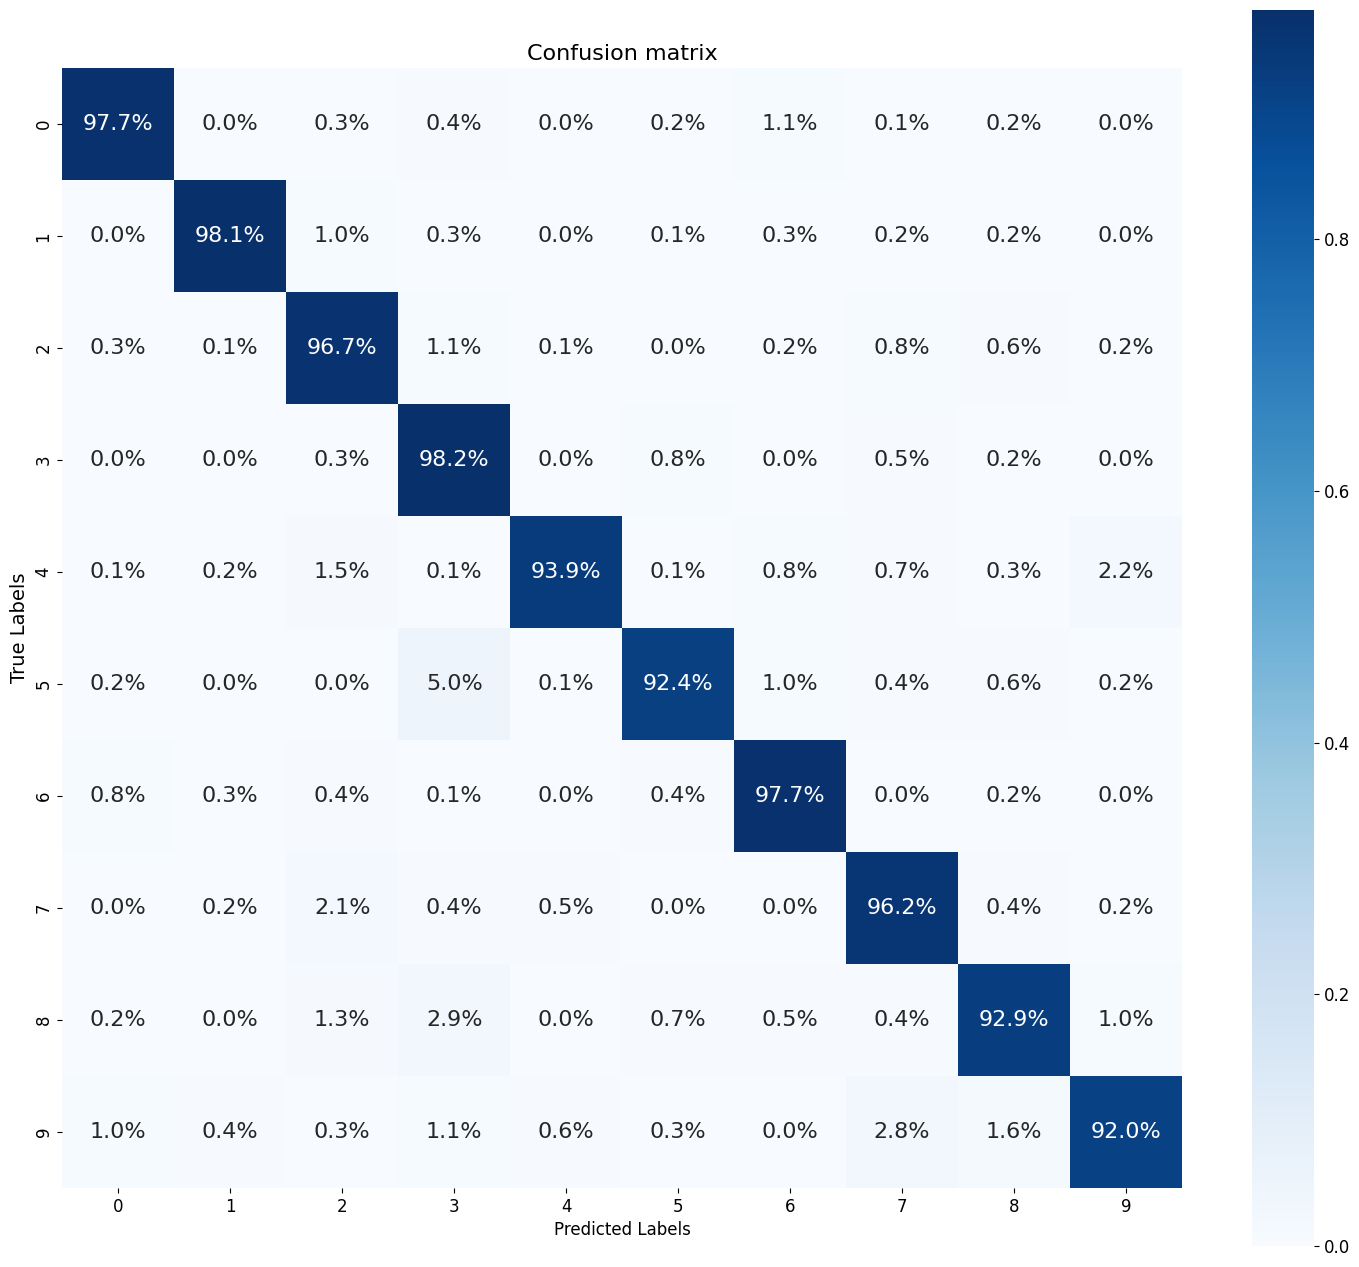

In [15]:
model = result["model"]
beta = result["beta_final"]

plot_confusion_matrix(X_test, y_test, model, beta, convert_to_percent=True)


# X_train_plot = jnp.transpose(X_train[:, :, :, :].copy(), [0, 2, 3, 1])
# X_test_plot = jnp.transpose(X_test[:, :, :, :].copy(), [0, 2, 3, 1])

# plot_faulty_predictions(X_test_plot, y_test, model, beta)

In [18]:
## A demonstration
epochs = 10
batch_size = 128 #4096 2048 # 128 # 1024
lr = 0.001 # 0.01
lam = 0.00000


for window_size in [7]:
    for n_filters_first in [1, 5, 10, 15]:
        for n_filters_second in [1, 15, 30, 45, 60]:
            result = single_run(X_train, X_test, y_train, y_test, 
                                lr=lr, lam=lam, window_size_list=[(window_size, n_filters_first), (window_size, n_filters_second)], hidden_layer_list=[128, 128],
                                epochs=epochs, batch_size=batch_size,
                                plot_or_not=False, result_filepath="convolutional_final_testing.json")
            print(f'Test: {result["test_accuracy"]}, Train:{result["train_accuracy"]}, Window size: {window_size}, N_filters_first:{n_filters_first}, N_filters_second:{n_filters_second}')

100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Test: 0.8885999917984009, Train:0.8820499777793884, Window size: 7, N_filters_first:1, N_filters_second:1


100%|██████████| 10/10 [02:47<00:00, 16.71s/it]


Test: 0.9749000072479248, Train:0.977649986743927, Window size: 7, N_filters_first:1, N_filters_second:15


100%|██████████| 10/10 [04:53<00:00, 29.31s/it]


Test: 0.9782999753952026, Train:0.9827666878700256, Window size: 7, N_filters_first:1, N_filters_second:30


100%|██████████| 10/10 [07:36<00:00, 45.69s/it]


Test: 0.9815999865531921, Train:0.9876499772071838, Window size: 7, N_filters_first:1, N_filters_second:45


100%|██████████| 10/10 [10:44<00:00, 64.44s/it]


Test: 0.9807999730110168, Train:0.9886500239372253, Window size: 7, N_filters_first:1, N_filters_second:60


100%|██████████| 10/10 [01:44<00:00, 10.49s/it]


Test: 0.9498000144958496, Train:0.9450833201408386, Window size: 7, N_filters_first:5, N_filters_second:1


100%|██████████| 10/10 [04:43<00:00, 28.32s/it]


Test: 0.9815999865531921, Train:0.9862833619117737, Window size: 7, N_filters_first:5, N_filters_second:15


100%|██████████| 10/10 [07:07<00:00, 42.76s/it]


Test: 0.9850000143051147, Train:0.9912333488464355, Window size: 7, N_filters_first:5, N_filters_second:30


100%|██████████| 10/10 [10:40<00:00, 64.05s/it]


Test: 0.987500011920929, Train:0.9943166375160217, Window size: 7, N_filters_first:5, N_filters_second:45


100%|██████████| 10/10 [15:38<00:00, 93.87s/it]


Test: 0.9886999726295471, Train:0.9955833554267883, Window size: 7, N_filters_first:5, N_filters_second:60


100%|██████████| 10/10 [02:17<00:00, 13.71s/it]


Test: 0.9483000040054321, Train:0.9462166428565979, Window size: 7, N_filters_first:10, N_filters_second:1


100%|██████████| 10/10 [05:29<00:00, 32.90s/it]


Test: 0.9854000210762024, Train:0.9903666377067566, Window size: 7, N_filters_first:10, N_filters_second:15


100%|██████████| 10/10 [07:32<00:00, 45.28s/it]


Test: 0.9868000149726868, Train:0.9926166534423828, Window size: 7, N_filters_first:10, N_filters_second:30


100%|██████████| 10/10 [11:07<00:00, 66.71s/it]


Test: 0.9882000088691711, Train:0.9952166676521301, Window size: 7, N_filters_first:10, N_filters_second:45


100%|██████████| 10/10 [16:33<00:00, 99.31s/it]


Test: 0.988099992275238, Train:0.9964166879653931, Window size: 7, N_filters_first:10, N_filters_second:60


100%|██████████| 10/10 [03:03<00:00, 18.40s/it]


Test: 0.949999988079071, Train:0.9476666450500488, Window size: 7, N_filters_first:15, N_filters_second:1


100%|██████████| 10/10 [06:05<00:00, 36.51s/it]


Test: 0.983299970626831, Train:0.9889666438102722, Window size: 7, N_filters_first:15, N_filters_second:15


100%|██████████| 10/10 [07:48<00:00, 46.90s/it]


Test: 0.9882000088691711, Train:0.9941166639328003, Window size: 7, N_filters_first:15, N_filters_second:30


100%|██████████| 10/10 [10:12<00:00, 61.23s/it]


Test: 0.9896000027656555, Train:0.9961000084877014, Window size: 7, N_filters_first:15, N_filters_second:45


100%|██████████| 10/10 [15:09<00:00, 90.96s/it]


Test: 0.9883999824523926, Train:0.996150016784668, Window size: 7, N_filters_first:15, N_filters_second:60


In [33]:
epochs = 10

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=lam, window_size_list=[(5, 15), (5, 45)], hidden_layer_list=[512],
                    epochs=epochs, batch_size=batch_size,
                    plot_or_not=False, result_filepath="test.json",
                    hidden_activation=nn.sigmoid)
print(f'Test: {result["test_accuracy"]}, Train:{result["train_accuracy"]}')

100%|██████████| 10/10 [11:50<00:00, 71.10s/it]


Test: 0.9861999750137329, Train:0.9949333071708679


In [24]:
print(f'Test: {result["test_accuracy"]}, Train:{result["train_accuracy"]}')

Test: 0.9858999848365784, Train:0.9950666427612305
